384 512 3


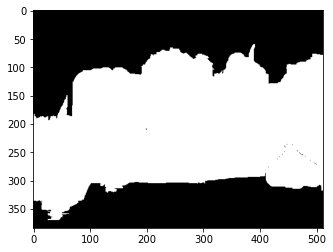

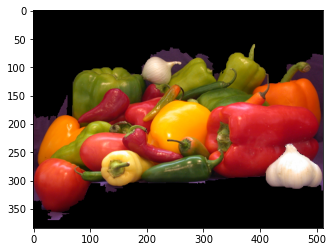

In [2]:
from cv2 import cv2
import numpy as np
import maxflow
import matplotlib.pyplot as plt
MAXVAL=1000000
sigma=2
def get_node_num(i, j, M):
    return j*M+i
def get_xy(nodenum, M):
    return nodenum % M, int(nodenum/M)
def parse_data(data):
    datafile=open(data)
    dataArr=[]
    for line in datafile.readlines():
        curpair=line.split("\t")
        curpair=list(map(int,curpair))
        dataArr.append((curpair[0]-1,curpair[1]-1))
    return dataArr

def const_G(I,M,N,bg,fg):
    G=np.array([0.5]*(M*N))
    G=np.reshape(G,(M,N))
    # print(G.shape)
    # print(bg[0])
    for i in range(len(bg)):
        G[bg[i][0]][bg[i][1]] = 0
    for i in range(len(fg)):
        G[fg[i][0]][fg[i][1]] = 1
    return G
def VertexEdge(G,M,I):
    V=[]
    E=[]
    for i in range(M):
        for j in range(N):
            if G[i,j]==0:#bg
                V.append((get_node_num(j,i,N), MAXVAL, 0))
            elif G[i,j]==1:
                V.append((get_node_num(j,i,N), 0, MAXVAL))
            else:
                V.append((get_node_num(j,i,N), 0, 0))
    for i in range(M-1):
        for j in range(N-1):
            state=get_node_num(j,i,N)
            nstate=get_node_num(j+1,i,N)
            tmp=-np.sum((I[i,j]-I[i,j+1].astype(np.float64))**2)
            w = np.exp(tmp/2/sigma/sigma)
            E.append((state,nstate,w))
            
            nstate=get_node_num(j,i+1,N)
            tmp=-np.sum((I[i,j]-I[i+1,j].astype(np.float64))**2)
            w = np.exp(tmp/2/sigma/sigma)
            E.append((state,nstate,w))
    return V,E

def find_maxflow(I,V,E,M):
    mask = np.zeros_like(I, dtype=bool)
    g = maxflow.Graph[float](len(V), len(E))
    vArr = g.add_nodes(len(V))
    for v in V:
        # add edges between a non-terminal node and terminal nodes
        # Add an edge ‘SOURCE->i’ with capacity cap_source and another edge ‘i->SINK’ with capacity cap_sink. 
        # This method can be called multiple times for each node. Capacities can be negative.
        g.add_tedge(vArr[v[0]], v[1], v[2])
    for e in E:
        # add_edge(self, int i, int j, long capacity, long rcapacity) 
        # Adds a bidirectional edge between nodes i and j with the weights cap and rev_cap.
        g.add_edge(e[0], e[1], e[2], e[2])
    g.maxflow()
    for idx in range(len(V)):
        # Returns which segment the given node belongs to.
        if g.get_segment(idx) == 1:
            i,j=get_xy(idx, N)
            mask[j,i]=(1,1,1)
    return mask
def visulize(mask):
    res = np.zeros_like(I)
    np.copyto(res, I, where=mask)
    plt.imshow(mask.astype(np.float))
    plt.show()
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.show()

def runGC(I,M,N,bg,fg):
    G=const_G(I,M,N,bg,fg)
    V,E=VertexEdge(G,M,I)
    mask=find_maxflow(I,V,E,M)
    return mask



I=cv2.imread("pepper.png")
bg=parse_data('points/bg_points.txt')

gpart=parse_data('points/gpart_points.txt')
rpart=parse_data('points/rpart_points.txt')
wpart=parse_data('points/wpart_points.txt')
ypart=parse_data('points/ypart_points.txt')
fg=gpart+rpart+wpart+ypart
M,N,P=I.shape
print(M,N,P)

mask=runGC(I,M,N,bg,fg)
visulize(mask)

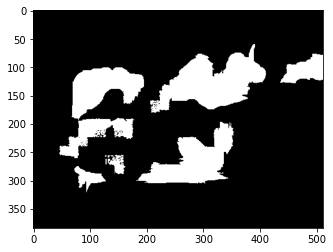

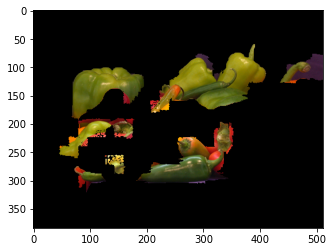

In [3]:
fg_g=gpart
bg_g=bg+rpart+wpart+ypart
mask=runGC(I,M,N,bg_g,fg_g)
visulize(mask)

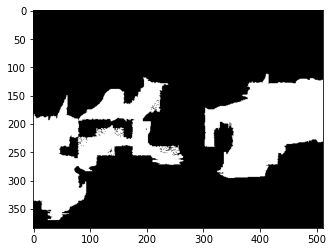

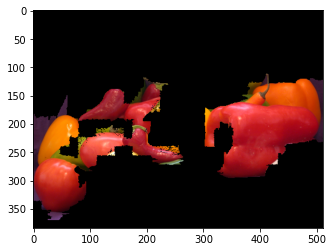

In [4]:
fg_r=rpart
bg_r=bg+gpart+wpart+ypart
mask=runGC(I,M,N,bg_r,fg_r)
visulize(mask)

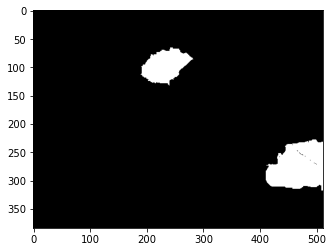

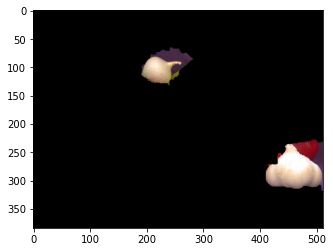

In [5]:
fg_w=wpart
bg_w=bg+gpart+rpart+ypart
mask=runGC(I,M,N,bg_w,fg_w)
visulize(mask)